In [2]:
#2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

policy_raw = pd.read_csv('policy_growth.csv')
exposure_raw = pd.read_csv('exposure_growth_data.csv')

def clean_column(series):
    return (
        series.astype(str)  # Convert to string (in case of mixed types)
        .str.replace('$', '', regex=False)  # Remove dollar signs
        .str.replace(',', '', regex=False)  # Remove commas
        .str.replace(' ', '')  # Remove spaces
        .str.replace('%', '')  # Remove spaces
        .str.strip()  # Trim whitespace
        .pipe(pd.to_numeric, errors='coerce')  # Convert to numeric
    )


exposure = exposure_raw.apply(clean_column)
exposure = exposure.groupby('ZIP Code').first().reset_index()

policy = policy_raw.apply(clean_column)
policy = policy[policy['ZIP Code']>1].set_index('ZIP Code').reset_index()


exposure_growth = exposure[['ZIP Code','YoY Growth 2024', 'YoY Growth 2023', 'YoY Growth 2022', 'YoY Growth 2021']]
exposure_total = exposure[['ZIP Code','Total Exposure 2024', 'Total Exposure 2023', 'Total Exposure 2022', 'Total Exposure 2021', 'Total Exposure 2020' ]]

policy_growth = policy[['ZIP Code','YoY Growth 2024', 'YoY Growth 2023', 'YoY Growth 2022', 'YoY Growth 2021']]
policy_total = policy[['ZIP Code','Total Policies 2024', 'Total Policies 2023', 'Total Policies 2022', 'Total Policies 2021', 'Total Policies 2020' ]]

exposure_growth

# np.array([policy['ZIP Code']].head(20))
# policy['ZIP Code'] = policy['ZIP Code'].astype(int)

# growth = policy.merge(exposure, on='ZIP Code')
# growth

,ZIP Code,YoY Growth 2024,YoY Growth 2023,YoY Growth 2022,YoY Growth 2021
0,90001.0,13.5,7.9,6.2,5.2
1,90002.0,18.7,6.1,6.8,1.9
2,90003.0,26.6,10.6,6.9,1.1
3,90004.0,32.1,25.1,1.2,1.7
4,90005.0,53.1,9.9,-3.0,16.9
...,...,...,...,...,...
1660,96146.0,17.9,23.7,21.9,90.4
1661,96148.0,24.9,58.5,50.6,110.7
1662,96150.0,27.3,42.2,27.8,57.3
1663,96161.0,24.7,40.7,55.7,61.0


In [3]:

exp_long = exposure_growth.melt(
    id_vars='ZIP Code',
    var_name='Year_Column',
    value_name='YoY Growth'
)

exp_long['Year'] = (exp_long['Year_Column'].str.extract(r'(\d{4})').astype(int))
exp_long = exp_long.drop(columns='Year_Column')
exp_long.rename(columns = {'YoY Growth':'Exposure Growth Average'}, inplace = True)

pol_long = policy_growth.melt(
    id_vars='ZIP Code',
    var_name='Year_Column',
    value_name='YoY Growth'
)

pol_long['Year'] = (pol_long['Year_Column'].str.extract(r'(\d{4})').astype(int))
pol_long = pol_long.drop(columns='Year_Column')
pol_long.rename(columns = {'YoY Growth':'Policy Growth Average'}, inplace = True)

exp_grouped = exp_long.groupby('Year').mean()
exp_grouped = exp_grouped[exp_grouped.columns[1:]]
# exp_grouped.rename(columns = {'YoY Growth':'Exposure Growth Average'}, inplace = True)

pol_grouped = pol_long.groupby('Year').mean()
pol_grouped = pol_grouped[pol_grouped.columns[1:]]
# pol_grouped.rename(columns = {'YoY Growth':'Policy Growth Average'}, inplace = True)
pol_grouped

total_growth = exp_grouped.merge(pol_grouped, on = 'Year')
total_growth

,Exposure Growth Average,Policy Growth Average
Year,,
2021,44.093934,32.316627
2022,37.950991,29.371369
2023,66.084024,44.882893
2024,161.543483,114.920048


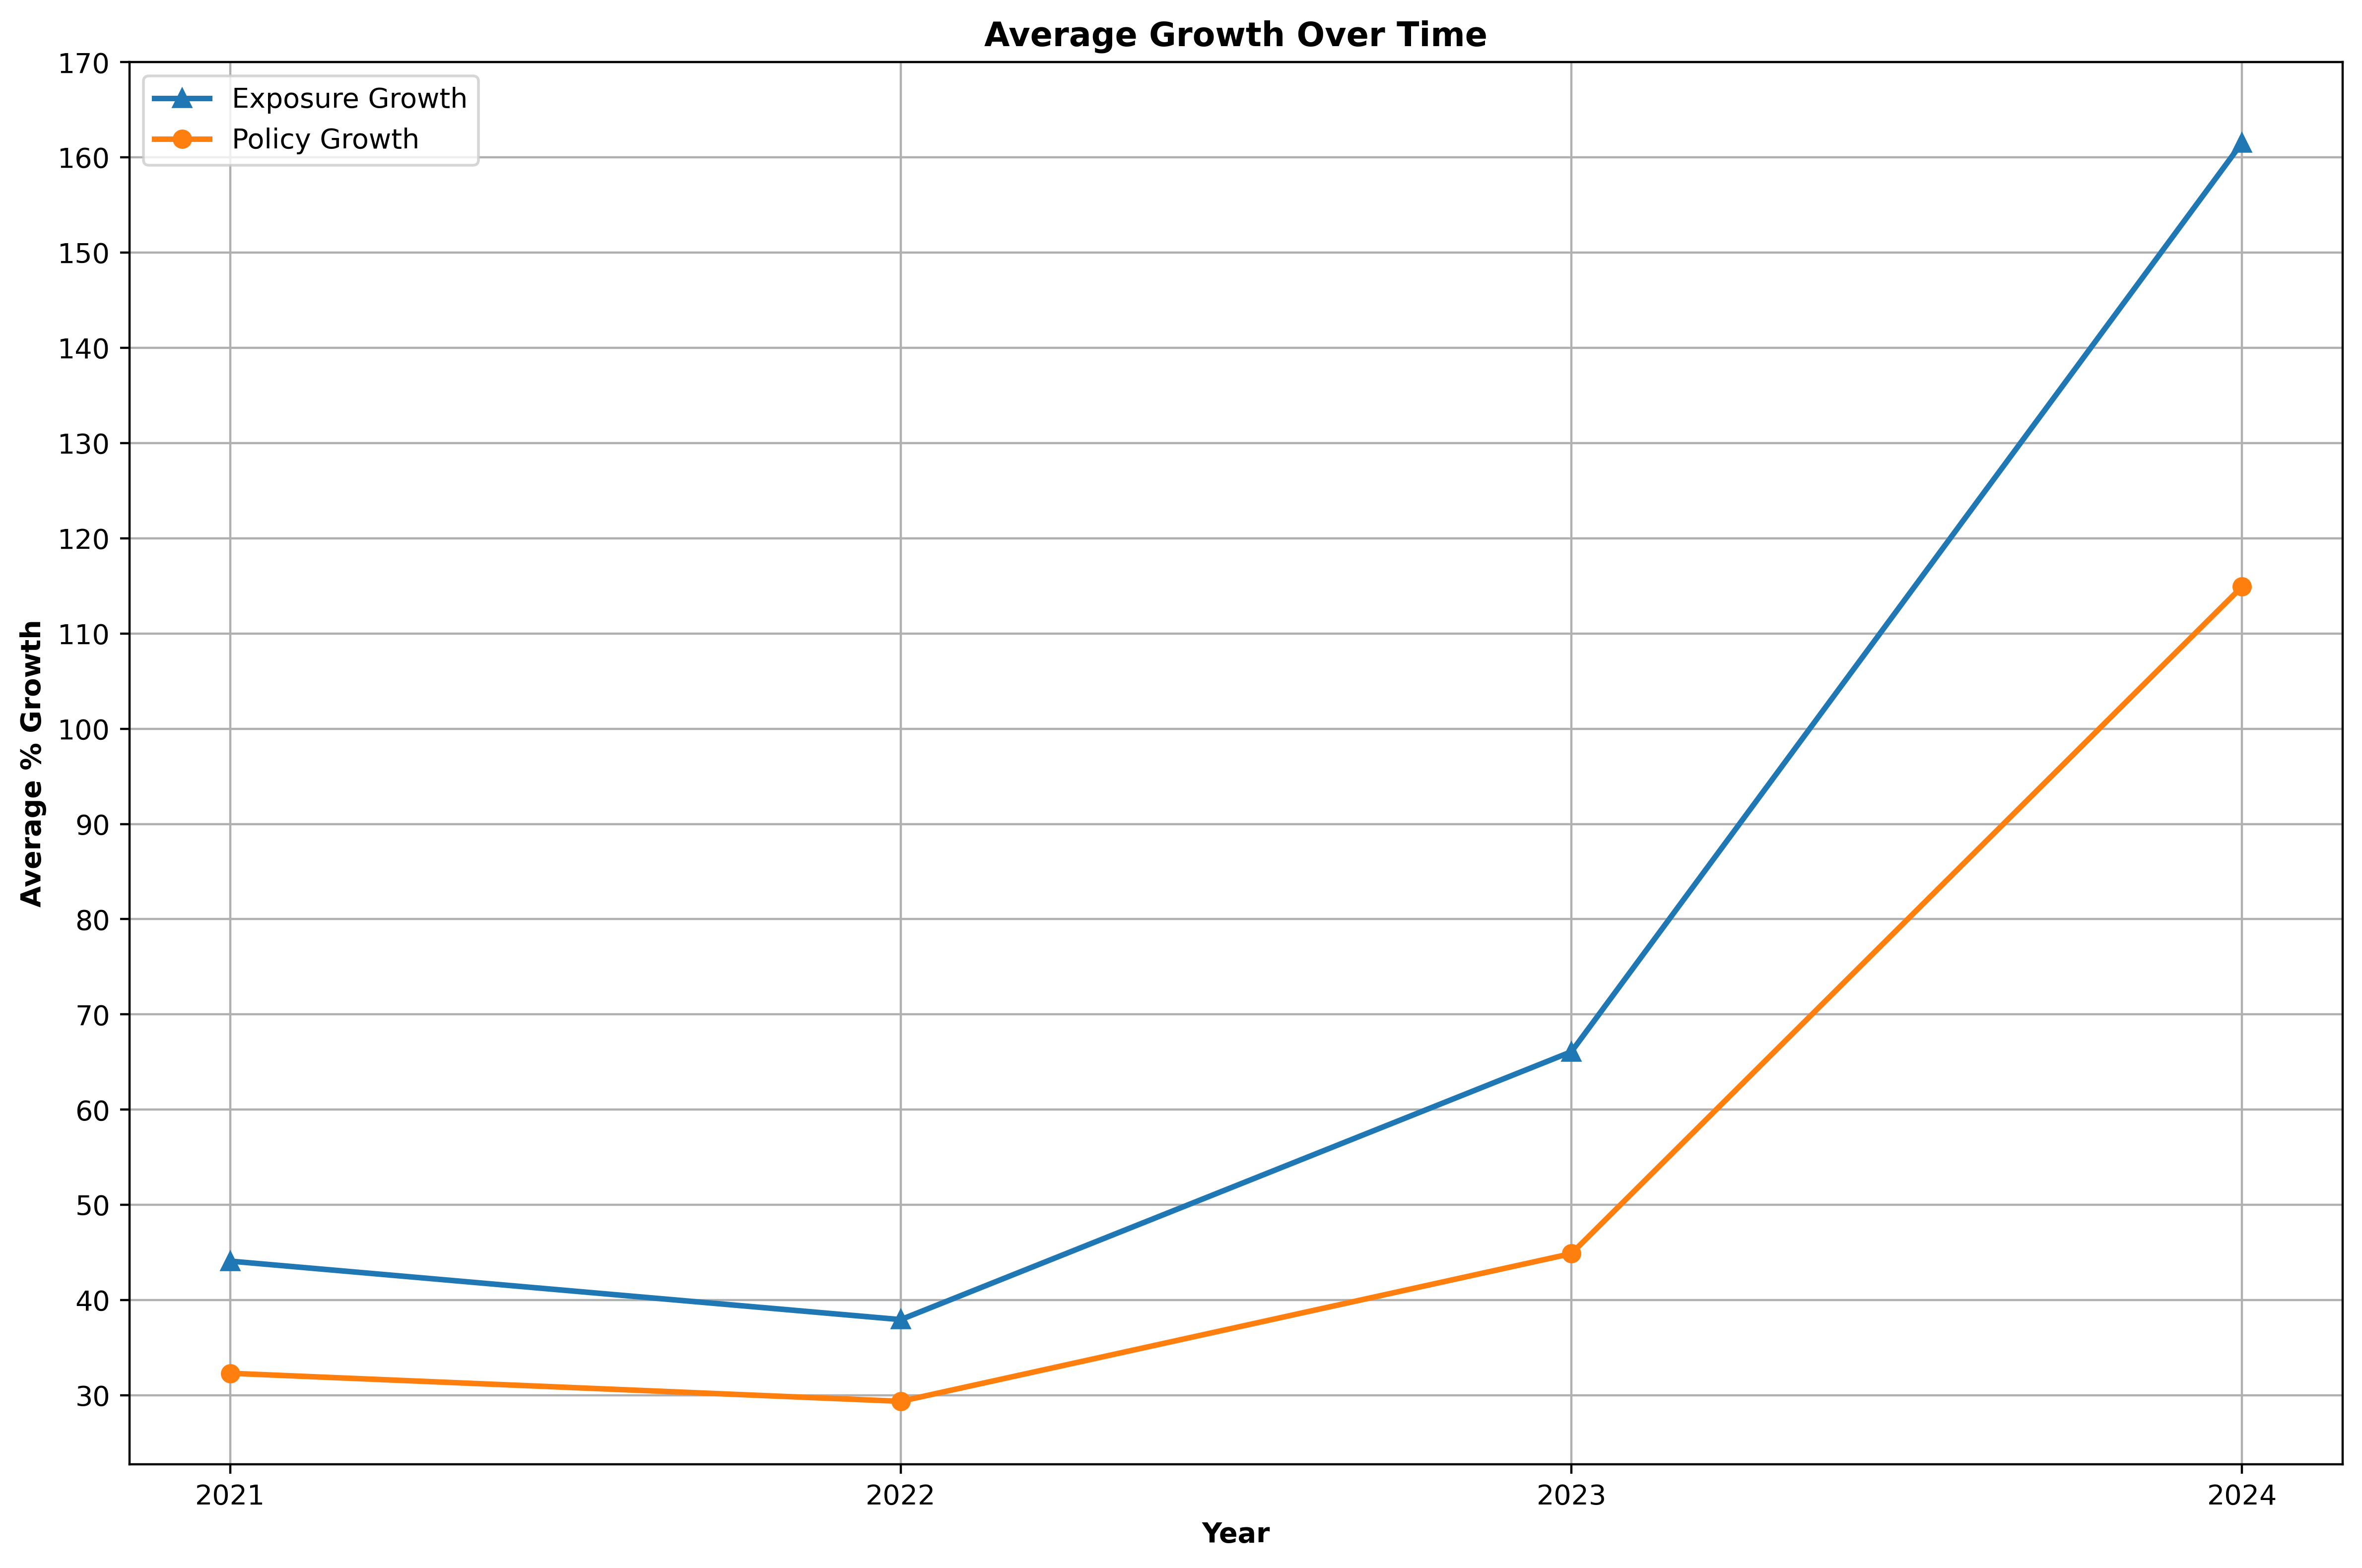

In [14]:
plt.figure(figsize=(12, 8), dpi=400)

plt.plot(total_growth.index, total_growth['Exposure Growth Average'], marker='^', label='Exposure Growth', linewidth=2)
plt.plot(total_growth.index, total_growth['Policy Growth Average'], marker='o', label='Policy Growth', linewidth=2)

# Labels & Title
plt.title('Average Growth Over Time', fontweight='bold')
plt.xlabel('Year', fontweight='bold')
plt.ylabel('Average % Growth', fontweight='bold')


# for year in total_growth.index:
#     e = total_growth.loc[year, 'Exposure Growth Average']
#     p = total_growth.loc[year, 'Policy Growth Average']
#     diff = e-p
    
#     y = max(e,p)+4
#     plt.text(year,y,f"+{diff:.1f}%", ha = 'center', fontsize=8)

plt.xticks(ticks=np.arange(2021,2025))
plt.yticks(ticks=(np.arange(30,180,10)))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
#t-test

def affected(zipcode):
    affected = (91001,91003,91011,91012,91020,91021,91024,91025,91101,91102,
                91103,91104,91105,91106,91107,91108,91109,91110,91114,91115,
                91116,91117,91121,91123,91124,91125,91126,91129,91182,91184,
                91185,91188,91189,91199)

    if zipcode in affected:
        return True
    else:
        return False
        
merged = exp_long.merge(pol_long, on = ['ZIP Code','Year'])
merged['Affected'] = merged['ZIP Code'].apply(affected)

undermarketed = pd.read_csv(r'C:\VS Code\LA_Fires\UndermarketedZIP_Codes.csv')
undermarketed['ZIP Code'] = undermarketed['ZIP Code'].astype(int)

def is_undermarketed(zipcode):
    if zipcode in np.array(undermarketed['ZIP Code']):
        return True
    else:
        return False
merged['Undermarketed'] = merged['ZIP Code'].apply(is_undermarketed)

merged.shape[0]-merged['Undermarketed'].sum() #number of non hazardous ZIP Codes




5312

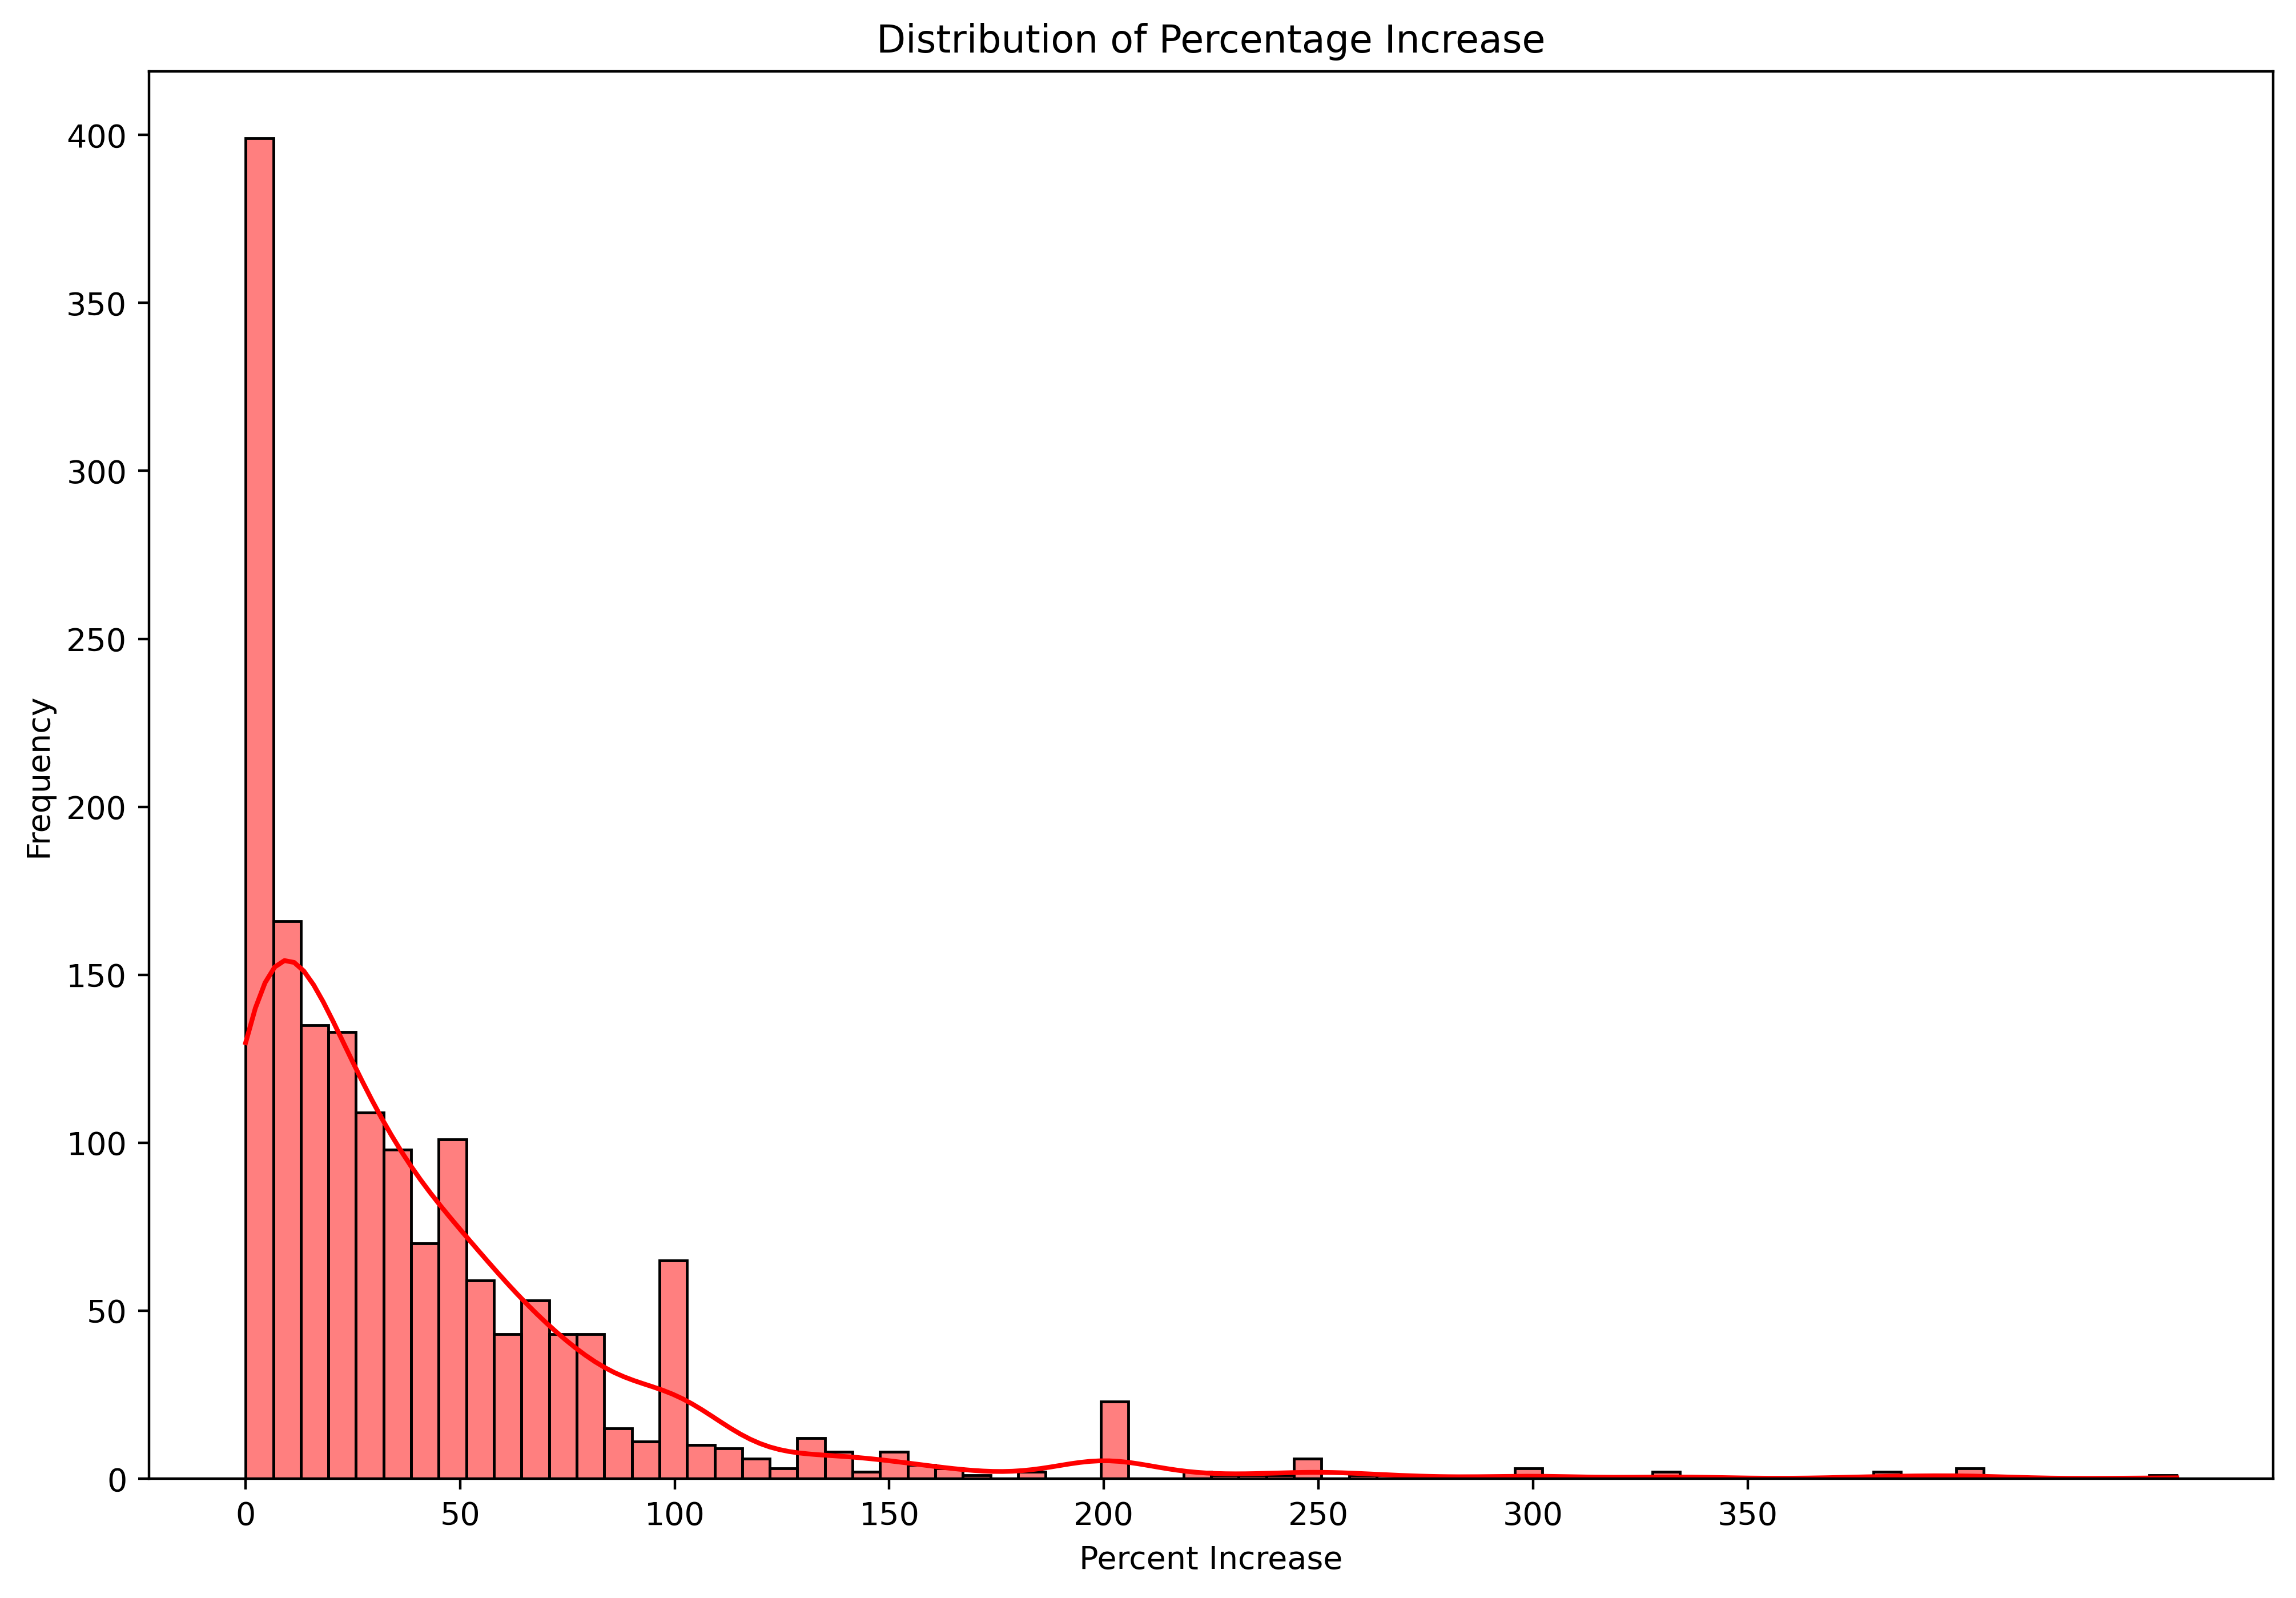

In [12]:
plt.figure(figsize=(12, 8), dpi=400)
sns.histplot(merged[(merged['Year']==2023) & (merged['Policy Growth Average']<500) ]['Policy Growth Average'], bins=70, kde=True, color='red')
plt.xticks(range(0,400, 50))  
plt.title('Distribution of Percentage Increase')
plt.xlabel('Percent Increase')
plt.ylabel('Frequency')
plt.show()

In [7]:
grouped = merged[merged['Policy Growth Average']<500].sort_values('Undermarketed').groupby(['Year','Undermarketed']).median()
grouped


ZIP Code  Exposure Growth Average  Policy Growth Average  \
Year Undermarketed                                                             
2021 False           93436.0                     13.2                  13.30   
     True            95489.0                     34.7                  24.20   
2022 False           93433.5                     14.4                  12.15   
     True            95488.0                     23.5                  14.60   
2023 False           93432.0                     43.8                  29.60   
     True            95489.0                     25.9                  18.25   
2024 False           93401.0                    103.0                  82.00   
     True            95486.5                     21.1                  16.15   

                    Affected  
Year Undermarketed            
2021 False               0.0  
     True                0.0  
2022 False               0.0  
     True                0.0  
2023 False               0.0  
     True                0.0  
2024 False               0.0  
     True                0.0

In [8]:
# Split the data
group_undermarketed = merged[merged['Undermarketed'] == True]['Policy Growth Average']
group_other = merged[merged['Undermarketed'] == False]['Policy Growth Average']

t_stat, p_val = ttest_ind(group_undermarketed, group_other, equal_var=False)

print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_val:.4f}")

if p_val < 0.05:
    print("Significant difference in policy growth between undermarketed and other ZIPs.")
else:
    print("No statistically significant difference detected.")

T-statistic: -15.581
P-value: 0.0000
Significant difference in policy growth between undermarketed and other ZIPs.


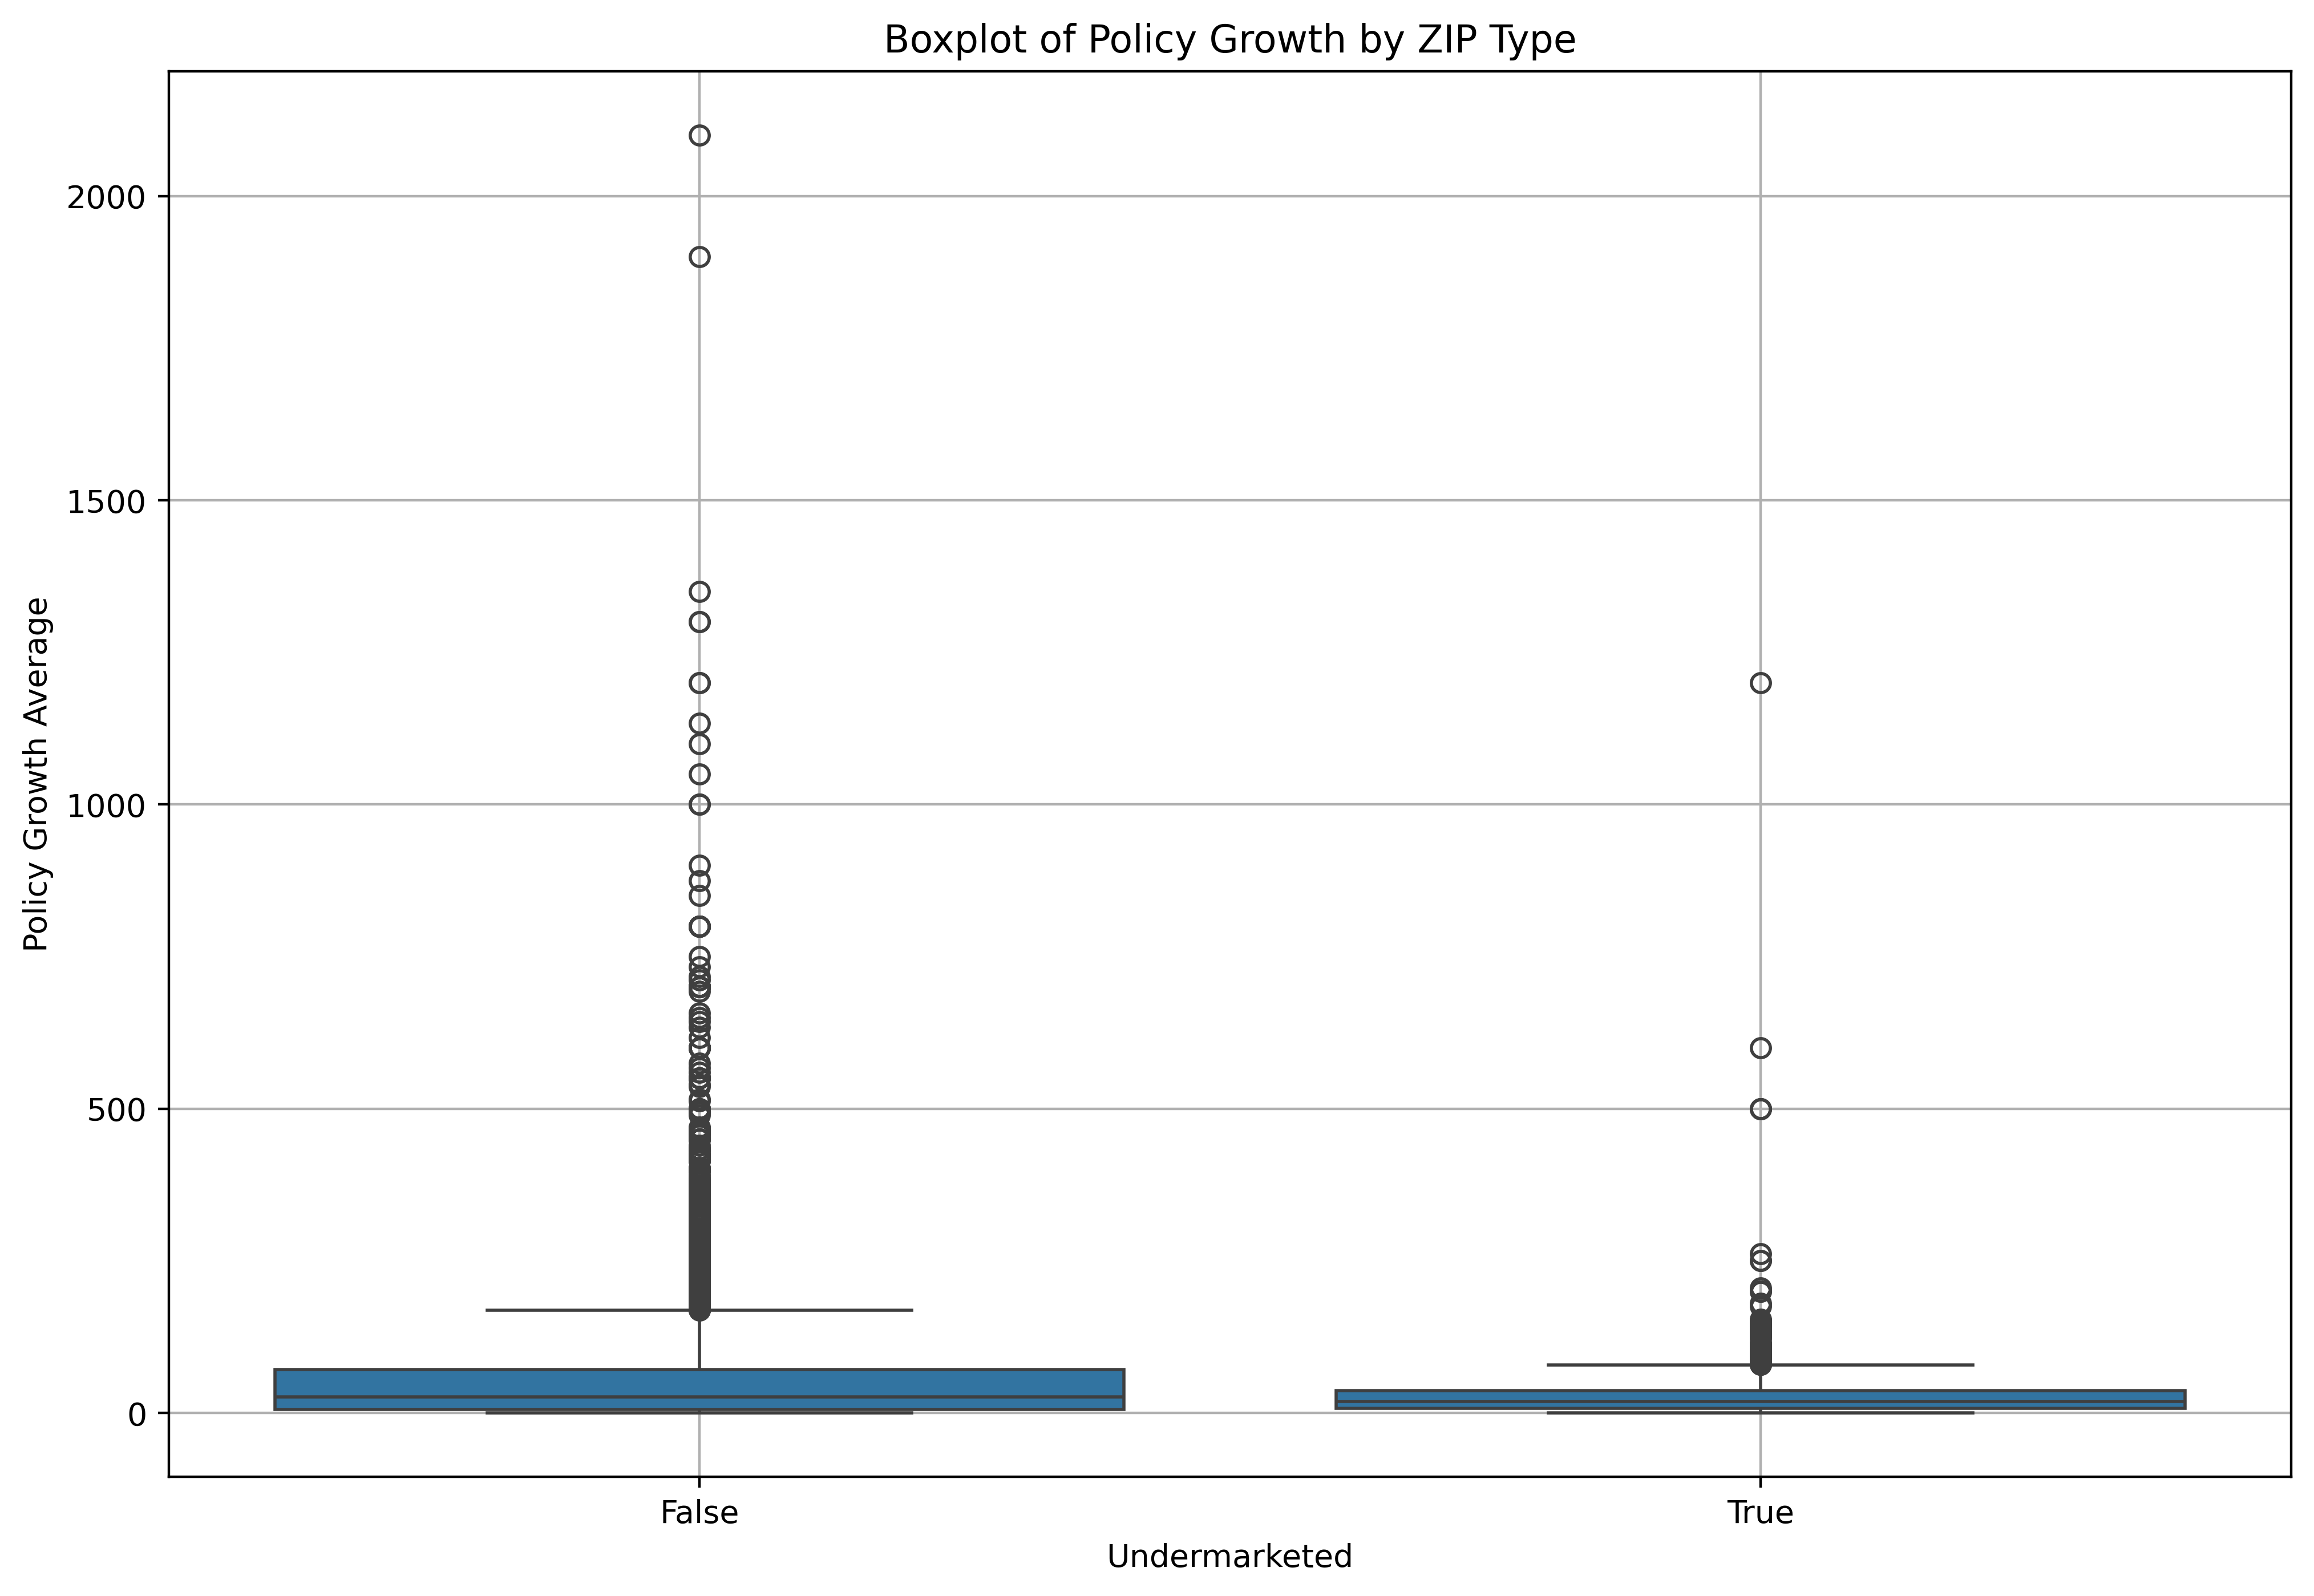

In [9]:
plt.figure(figsize=(12, 8), dpi=400)
sns.boxplot(data=merged, x='Undermarketed', y='Policy Growth Average')
plt.title("Boxplot of Policy Growth by ZIP Type")
plt.grid(True)
plt.show()

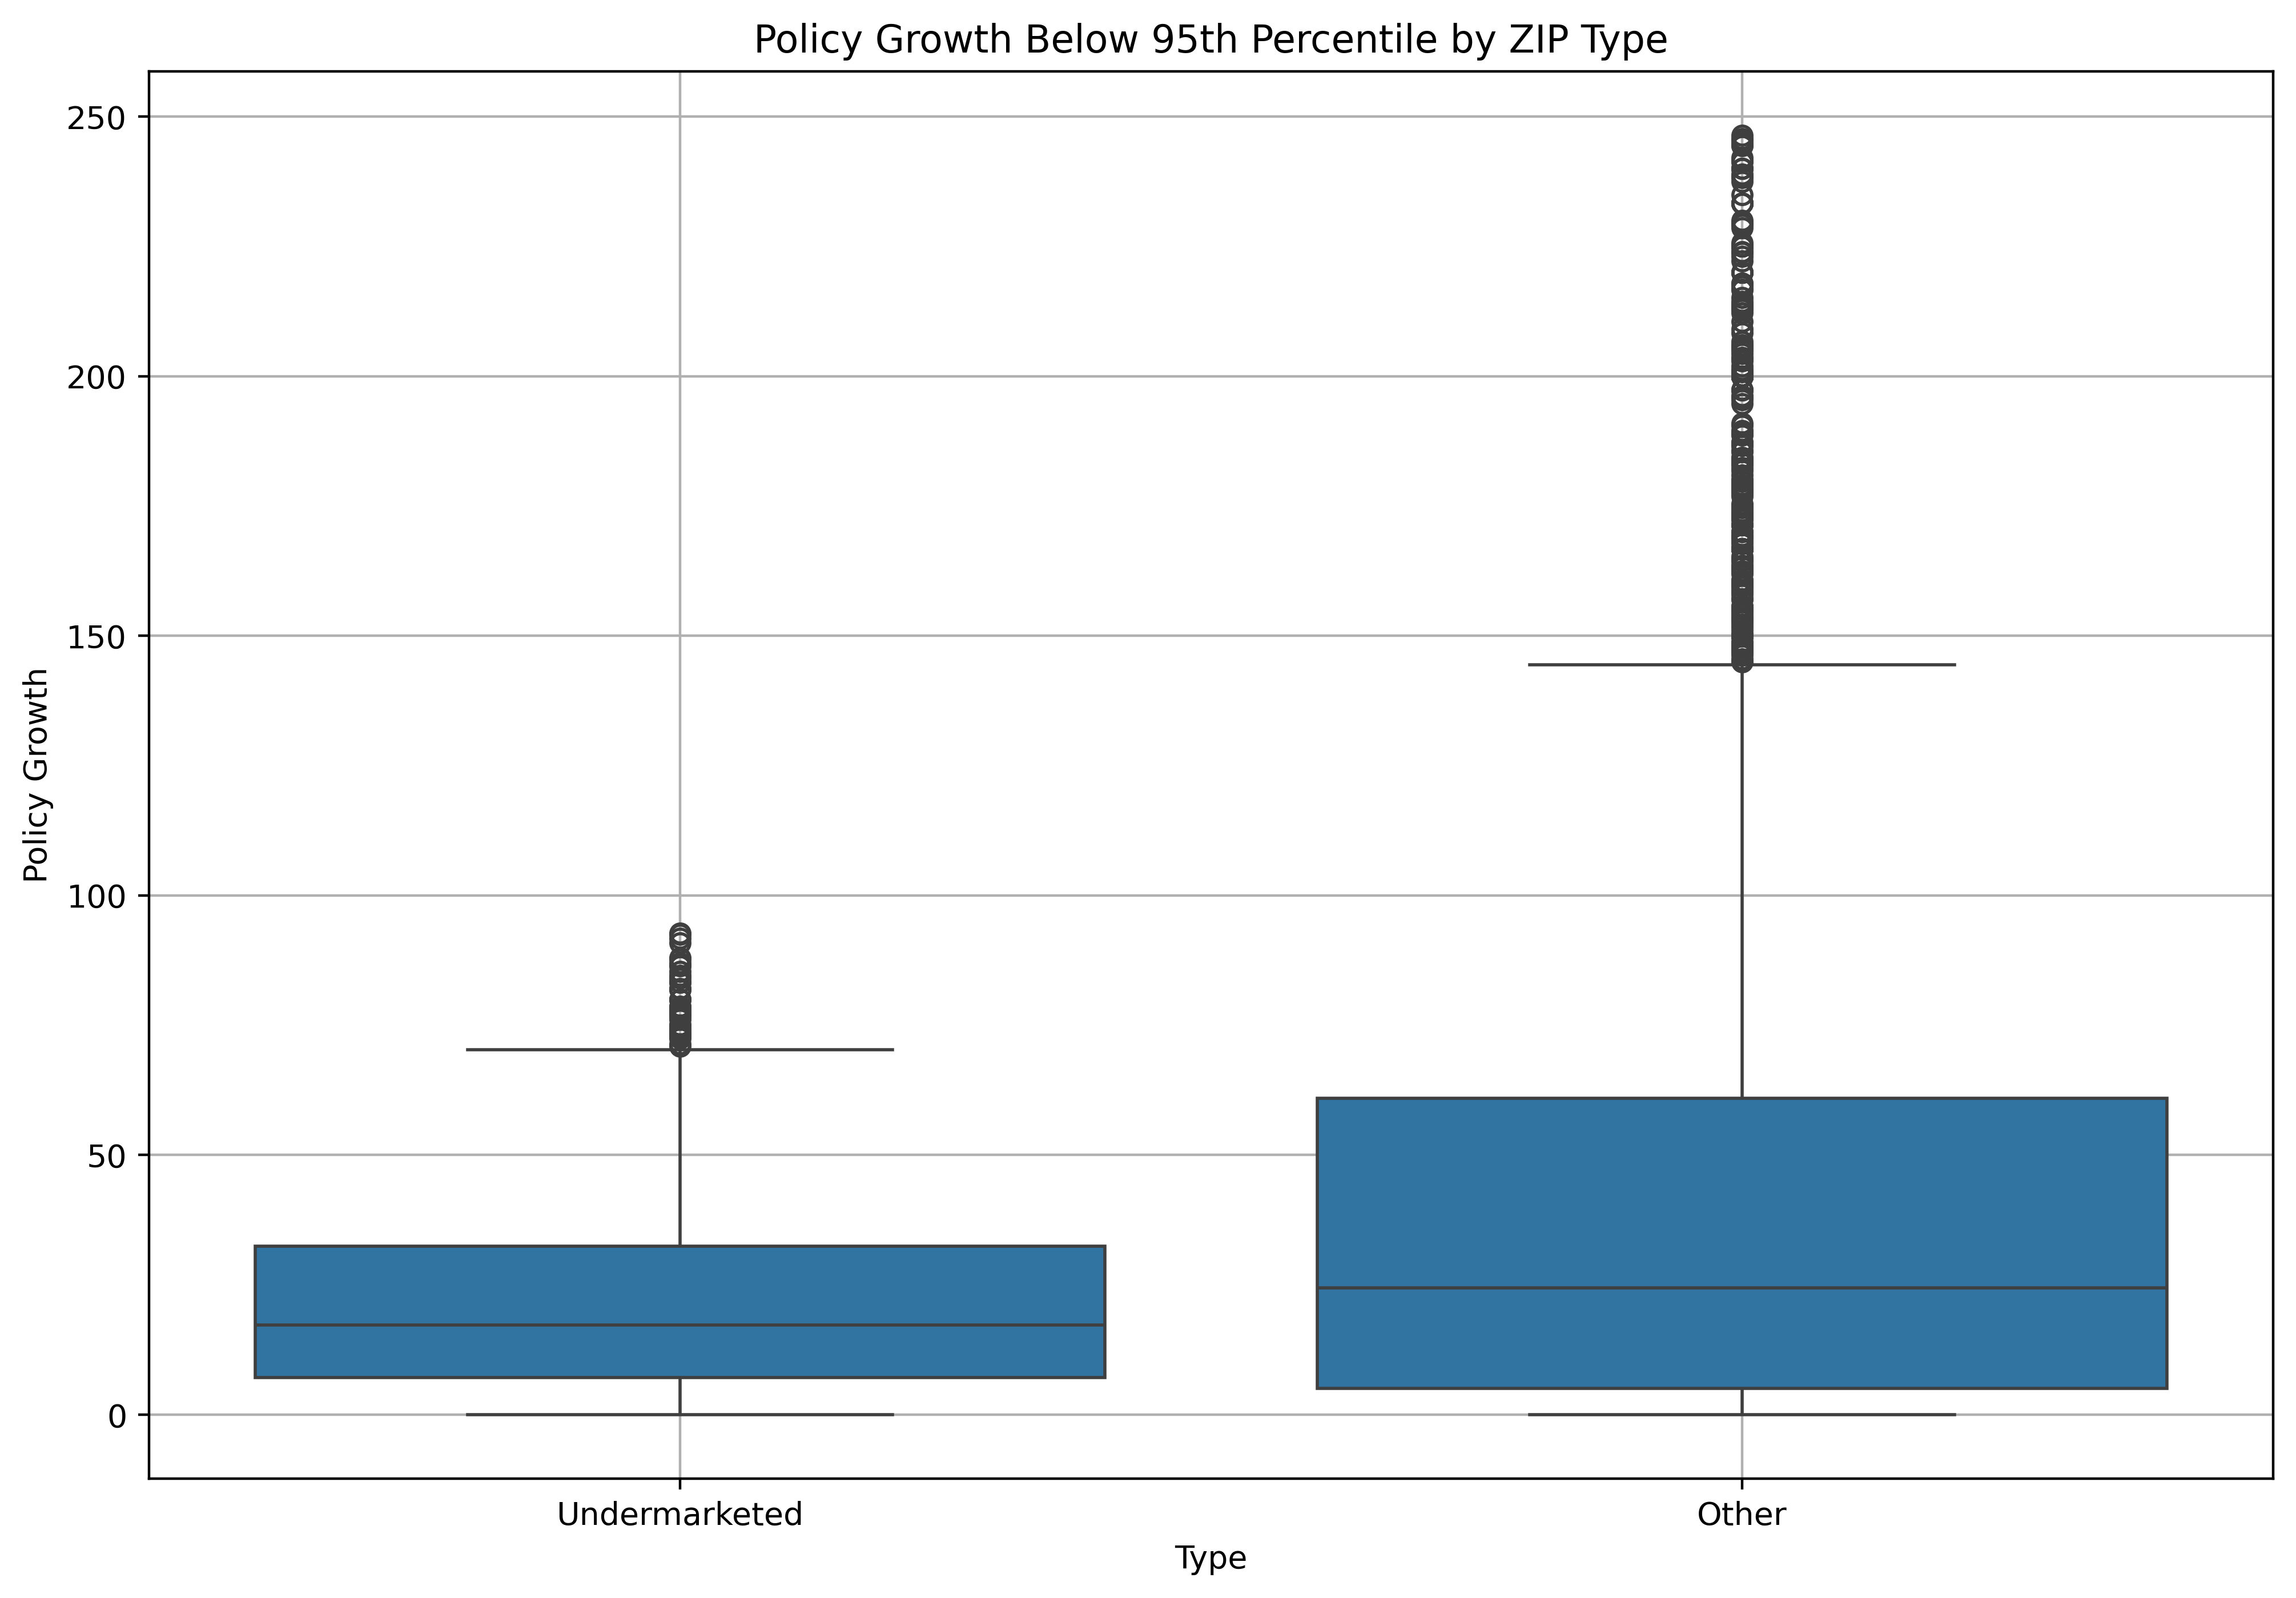

In [11]:
thresh_under = group_undermarketed[group_undermarketed <= group_undermarketed.quantile(.95)]
thresh_other = group_other[group_other <= group_other.quantile(.95)]


quartile_95 = pd.concat([
    pd.DataFrame({'Policy Growth': thresh_under, 
                  'Type': 'Undermarketed'}),
    pd.DataFrame({'Policy Growth': thresh_other, 
                  'Type': 'Other'})
])

plt.figure(figsize=(12, 8), dpi=400)
sns.boxplot(data=quartile_95, x='Type', y='Policy Growth')
plt.title("Policy Growth Below 95th Percentile by ZIP Type")
plt.grid(True)
plt.show()